# Info
Purpose:

    To Calculate aerosol optical properties for aerosol above cloud reitrewvals using MODIS and VIIRS
    Using the wavelengths: 
    0.47, 0.55, 0.67, 0.86, 1.24, 2.1µm
    
    - Using the retrieved size distributions
    - retrieval results of refractive index (imaginary and real) at wavelengths: 400, 500, 675, 870, 995 nm


Output:

    Figure and save files

Keywords:

    none

Dependencies:

    - load_utils.py
    - matplotlib
    - numpy
    - Sp_parameters
    - write_utils
    - path_utils
    - libradtran

Needed Files:
  - netcdf of aeroinv from ORACLES
  - ...

Modification History:

    Written: Samuel LeBlanc, Santa Cruz, CA, 2022-09-12
    Modified:


# Prepare python environment

In [161]:
import numpy as np
import Sp_parameters as Sp
import load_utils as lu
import write_utils as wu
from path_utils import getpath
import hdf5storage as hs
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib notebook
import os
import scipy.interpolate as si
import netCDF4 as nc

In [7]:
name = 'sunsat_ORACLES2016'
vv = 'v1'
fp = getpath(name)


Created new path: /data/sunsat/ORACLES_2016/ under the name: sunsat_ORACLES2016
Return path named:  sunsat_ORACLES2016 /data/sunsat/ORACLES_2016/


In [122]:
fp_bin = getpath('uvspec_bin')

Return path named:  uvspec_bin /home/sam/libradtran/libRadtran-2.0.2/bin/


In [27]:
fp_rtm0 = getpath('rtm')
fp_rtm = fp_rtm0 +'TASNPP_mie/'

Return path named:  rtm /scratch/rtm/


In [28]:
if not os.path.exists(fp_rtm): 
    os.mkdir(fp_rtm)

# Load files

In [8]:
f = fp + 'data_archival/AEROINV_nc_R0/NC_FORMAT_NETCDF4_CLASSIC/4STAR-aeroinv_P3_2016_R0.nc'

In [9]:
ae,ae_dict = lu.load_netcdf(f,everything=True)

Reading file: /data/sunsat/ORACLES_2016/data_archival/AEROINV_nc_R0/NC_FORMAT_NETCDF4_CLASSIC/4STAR-aeroinv_P3_2016_R0.nc
Outputting the Data subdatasets:
0: base_time
1: time_offset
2: time
3: wavelength
4: radius
5: psd
6: QA_level
7: sphericity
8: sphericity_err
9: PF_angle
10: sca_angle
11: n_real
12: n_imag
13: SSA
14: AOD_fit_total
15: AOD_fit_fine
16: AOD_fit_coarse
17: AOD_meas
18: AAOD
19: TOD_meas
20: TOD_fit
21: TOD_meas_minus_fit
22: AGOD
23: sfc_alb
24: g_total
25: g_fine
26: g_coarse
27: PF_total
28: PF_fine
29: PF_coarse
30: normalized_sky_radiance
31: normalized_sky_radiance_fit
32: sky_radiance_fit_error
33: scan_tag
34: scan_type
35: Lat
36: Lon
37: GPS_Altitude
38: Heading
39: Pitch
40: Roll
41: GPS_Altitude_std
42: Heading_std
43: Pitch_std
44: Roll_std
45: T_static
46: P_static
47: RH
48: SAZ
49: SZA
50: SEL
51: m_ray
52: PWV
[b'base_time', b'time_offset', b'time', b'wavelength', b'radius', b'psd', b'QA_level', b'sphericity', b'sphericity_err', b'PF_angle', b'sca_a

In [14]:
len(ae[b'time'])

86

# Run through each retrieval and make input files

## Prep functions for printing size distribution

From the libradtran documentation for mie size distribution file:  
>Specify a two column file, r [micron], dn(r)/dr, which describes a size distribution

In [34]:
def print_size_dist_file(fname,r,dnr):
    with open(fname,'w') as f:
        for ir,rr in list(enumerate(r)):
            f.write('{:3.10f} {:3.10f}\n'.format(rr,dnr[ir]))

In [20]:
ae_dict[b'radius']

<class 'netCDF4._netCDF4.Variable'>
float64 radius(radius)
    long_name: particle radius
    units: um
unlimited dimensions: 
current shape = (22,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [21]:
ae_dict[b'psd']

<class 'netCDF4._netCDF4.Variable'>
float64 psd(time, radius)
    long_name: particle size distribution
    units: dV/dlnR
    source: retrieval
unlimited dimensions: time
current shape = (86, 22)
filling on, default _FillValue of 9.969209968386869e+36 used

In [25]:
def convert_dvlnr_to_dndr(psd,r):
     # All about that conversion from the volume size distribution of dV(r)/dln(r) to number size distribution dN(r)/dr
    Nr = psd/(4.0*np.pi/3.0)
    for i,rr in list(enumerate(r)):
        Nr[i] = Nr[i]/rr**4.0
    return Nr

In [37]:
print_size_dist_file(fp_rtm+'mie_tester.psd',ae[b'radius'],convert_dvlnr_to_dndr(ae[b'psd'][0,:],ae[b'radius']))

## Prep function for printing index of refraction

In [38]:
ae_dict[b'n_real']

<class 'netCDF4._netCDF4.Variable'>
float64 n_real(time, wavelength)
    long_name: refractive index, real
    units: unitless
    source: retrieval
unlimited dimensions: time
current shape = (86, 5)
filling on, default _FillValue of 9.969209968386869e+36 used

In [39]:
ae_dict[b'n_imag']

<class 'netCDF4._netCDF4.Variable'>
float64 n_imag(time, wavelength)
    long_name: refractive index, imaginary
    units: unitless
    source: retrieval
unlimited dimensions: time
current shape = (86, 5)
filling on, default _FillValue of 9.969209968386869e+36 used

In [41]:
ae_dict[b'wavelength']

<class 'netCDF4._netCDF4.Variable'>
float64 wavelength(wavelength)
    long_name: wavelength
    units: nm
unlimited dimensions: 
current shape = (5,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [113]:
def spline_wavelength_extend(val,wavelen,new_wavelen,su=0.0006,k=2):
    # to calculate a new spline fit to the refractive index
    val_fx = si.CubicSpline(np.append(wavelen,wavelen[-1]+450.0),np.append(val,val[-1]),bc_type='natural',extrapolate=True)
    return val_fx(new_wavelen)

In [114]:
wave_out = np.array([470.0, 550.0, 670.0, 860.0, 1240.0, 2100.0])

<IPython.core.display.Javascript object>


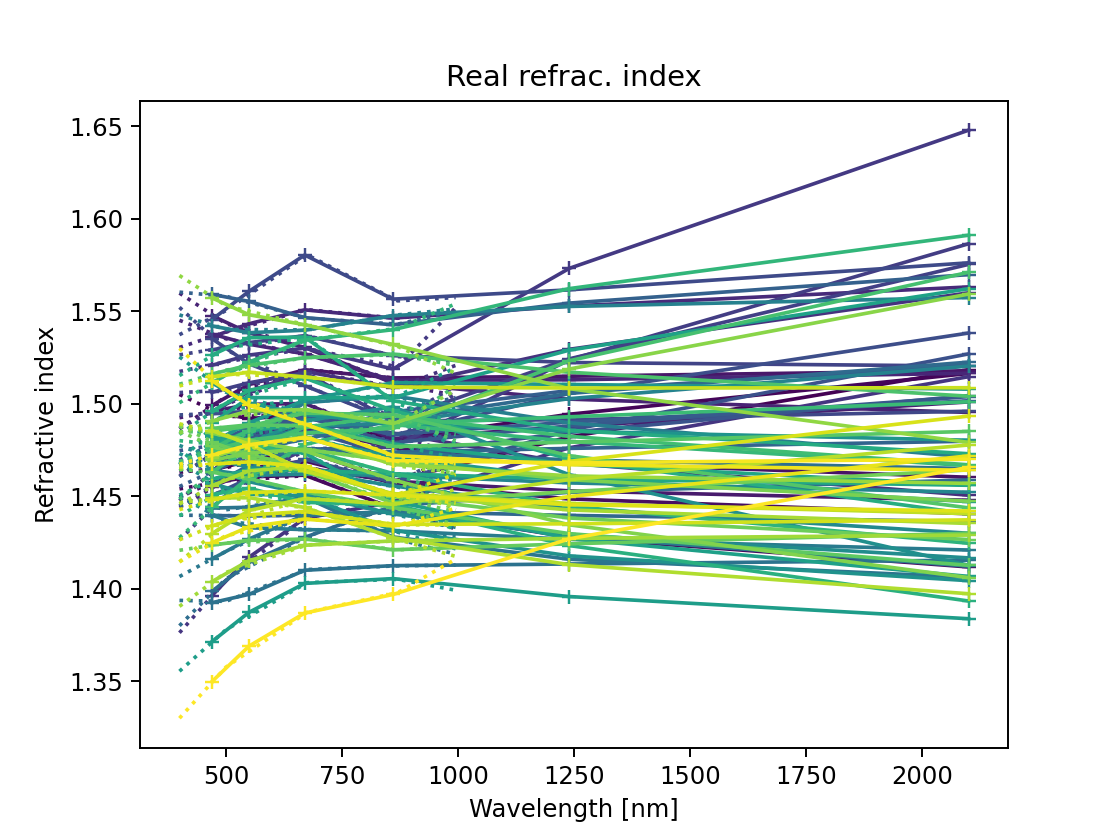

Text(0, 0.5, 'Refractive index')

In [115]:
fig,ax = plt.subplots(1,1)

for it,t in list(enumerate(ae[b'time'])):
    plt.plot(ae[b'wavelength'],ae[b'n_real'][it,:],':',c=plt.cm.viridis(it*3))
    plt.plot(wave_out,spline_wavelength_extend(ae[b'n_real'][it,:],ae[b'wavelength'],wave_out),
             '+-',c=plt.cm.viridis(it*3))
    
plt.title('Real refrac. index')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Refractive index')
    

<IPython.core.display.Javascript object>


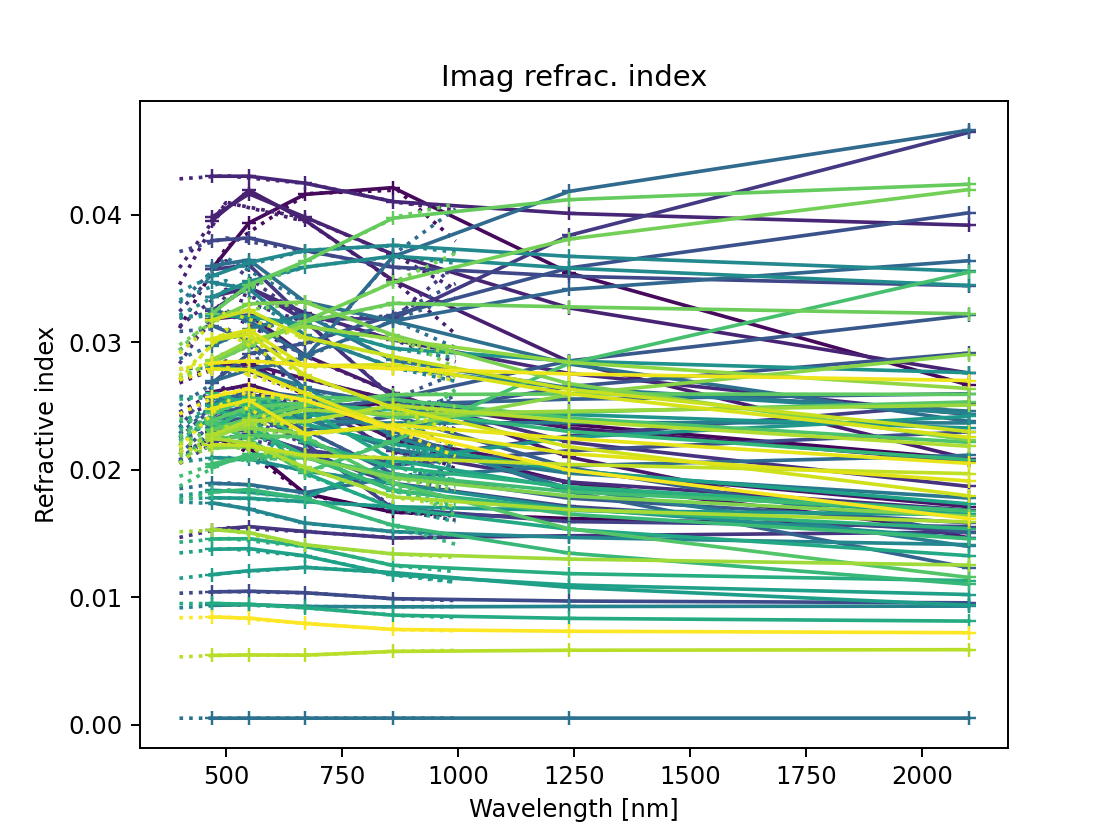

Text(0, 0.5, 'Refractive index')

In [116]:
plt.figure()
for it,t in list(enumerate(ae[b'time'])):
    plt.plot(ae[b'wavelength'],ae[b'n_imag'][it,:],':',c=plt.cm.viridis(it*3))
    plt.plot(wave_out,spline_wavelength_extend(ae[b'n_imag'][it,:],ae[b'wavelength'],wave_out),
         '+-',c=plt.cm.viridis(it*3))
    
plt.title('Imag refrac. index')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Refractive index')
    

In [117]:
def print_refrac_file(fname,wavelength,n_real,n_imag):
    #wavelength in nm, n_real and n_imag needs to be positive
    
    with open(fname,'w') as f:
        for iw,w in list(enumerate(wavelength)):
            f.write('{:4.3f} {:3.12f} {:3.12f}\n'.format(w,abs(n_real[iw]),abs(n_imag[iw])))

In [119]:
itest = 0
print_refrac_file(fp_rtm+'mie_tester.ref',wave_out,
                     spline_wavelength_extend(ae[b'n_real'][itest,:],ae[b'wavelength'],wave_out),
                     spline_wavelength_extend(ae[b'n_imag'][itest,:],ae[b'wavelength'],wave_out))

## Mie input file function

In [120]:
def mie_input(fname,refrac_file_name,size_dist_file_name,program='MIEV0'):
    #simple mie input file program
     with open(fname,'w') as f:
            f.write('mie_program {}\n'.format(program))
            f.write('refrac file {}\n'.format(refrac_file_name))
            f.write('size_distribution_file {}\n'.format(size_dist_file_name))
            
    

In [121]:
mie_input(fp_rtm+'mie_tester.inp',fp_rtm+'mie_tester.ref',fp_rtm+'mie_tester.psd')

# Run through and make input files for scans

In [126]:
base = 'mie_ORACLES2016_expansion'
f_list = fp_rtm+base+'_list.sh'
with open(f_list,'w') as f:
    for it,tt in list(enumerate(ae[b'time'])):
        basename = base+'_{:03.0f}'.format(it)
        print_refrac_file(fp_rtm+basename+'.ref',wave_out,
                         spline_wavelength_extend(ae[b'n_real'][it,:],ae[b'wavelength'],wave_out),
                         spline_wavelength_extend(ae[b'n_imag'][it,:],ae[b'wavelength'],wave_out))
        print_size_dist_file(fp_rtm+basename+'.psd',ae[b'radius'],convert_dvlnr_to_dndr(ae[b'psd'][it,:],ae[b'radius']))
        mie_input(fp_rtm+basename+'.inp',fp_rtm+basename+'.ref',fp_rtm+basename+'.psd')
        f.write('{bin_path}mie < {inp} > {out}\n'.format(bin_path=fp_bin,inp=fp_rtm+basename+'.inp',out=fp_rtm+basename+'.out'))

In [128]:
%ls $fp_rtm

mie_ORACLES2016_expansion_000.inp  mie_ORACLES2016_expansion_044.inp
mie_ORACLES2016_expansion_000.psd  mie_ORACLES2016_expansion_044.psd
mie_ORACLES2016_expansion_000.ref  mie_ORACLES2016_expansion_044.ref
mie_ORACLES2016_expansion_001.inp  mie_ORACLES2016_expansion_045.inp
mie_ORACLES2016_expansion_001.psd  mie_ORACLES2016_expansion_045.psd
mie_ORACLES2016_expansion_001.ref  mie_ORACLES2016_expansion_045.ref
mie_ORACLES2016_expansion_002.inp  mie_ORACLES2016_expansion_046.inp
mie_ORACLES2016_expansion_002.psd  mie_ORACLES2016_expansion_046.psd
mie_ORACLES2016_expansion_002.ref  mie_ORACLES2016_expansion_046.ref
mie_ORACLES2016_expansion_003.inp  mie_ORACLES2016_expansion_047.inp
mie_ORACLES2016_expansion_003.psd  mie_ORACLES2016_expansion_047.psd
mie_ORACLES2016_expansion_003.ref  mie_ORACLES2016_expansion_047.ref
mie_ORACLES2016_expansion_004.inp  mie_ORACLES2016_expansion_048.inp
mie_ORACLES2016_expansion_004.psd  mie_ORACLES2016_expansion_048.psd
mie_ORACLES2016_expansion_004.ref 

In [133]:
!parallel --jobs=22 --bar < $f_list

0% 0:86=0s /home/sam/libradtran/libRadtran-2.0.2/bin/mie < /scratch/rtm/TASNPP_m ... read 6 data points from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_000.ref
1% 1:85=0s /home/sam/libradtran/libRadtran-2.0.2/bin/mie < /scratch/rtm/TASNPP_m ... read 6 data points from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_001.ref
2% 2:84=0s /home/sam/libradtran/libRadtran-2.0.2/bin/mie < /scratch/rtm/TASNPP_m ... read 6 data points from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_002.ref
3% 3:83=0s /home/sam/libradtran/libRadtran-2.0.2/bin/mie < /scratch/rtm/TASNPP_m ... read 6 data points from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_003.ref
4% 4:82=0s /home/sam/libradtran/libRadtran-2.0.2/bin/mie < /scratch/rtm/TASNPP_m ... read 6 data points from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_004.ref
5% 5:81=0s /home/sam/libradtran/libRadtran-2.0.2/bin/mie < /scratch/rtm/TASNPP_m ... read 6 data points from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_005.re

61% 53:33=0s /home/sam/libradtran/libRadtran-2.0.2/bin/mie < /scratch/rtm/TASNPP ... read 6 data points from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_053.ref
62% 54:32=0s /home/sam/libradtran/libRadtran-2.0.2/bin/mie < /scratch/rtm/TASNPP ... read 6 data points from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_054.ref
63% 55:31=0s /home/sam/libradtran/libRadtran-2.0.2/bin/mie < /scratch/rtm/TASNPP ... read 6 data points from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_055.ref
65% 56:30=0s /home/sam/libradtran/libRadtran-2.0.2/bin/mie < /scratch/rtm/TASNPP ... read 6 data points from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_056.ref
66% 57:29=0s /home/sam/libradtran/libRadtran-2.0.2/bin/mie < /scratch/rtm/TASNPP ... read 6 data points from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_057.ref
67% 58:28=0s /home/sam/libradtran/libRadtran-2.0.2/bin/mie < /scratch/rtm/TASNPP ... read 6 data points from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_058.re

97% 84:2=0s /home/sam/libradtran/libRadtran-2.0.2/bin/mie < /scratch/rtm/TASNPP_ ... read 6 data points from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_084.ref
98% 85:1=0s /home/sam/libradtran/libRadtran-2.0.2/bin/mie < /scratch/rtm/TASNPP_ ... read 6 data points from /scratch/rtm/TASNPP_mie/mie_ORACLES2016_expansion_085.ref
100% 86:0=0s /home/sam/libradtran/libRadtran-2.0.2/bin/mie < /scratch/rtm/TASNPP


## Read the mie output files

In [134]:
fname = fp_rtm+basename+'.out'

In [135]:
outs = np.genfromtxt(fname)

In [141]:
outs[:,]

array([-1., -1., -1., -1., -1., -1.])

In [143]:
def read_mie_output(fname):
    # read the default ascii output file from mie code
    outs = np.genfromtxt(fname)
    d = {}
    d['wavelength'] = outs[:,0]
    d['n_real'] = outs[:,1]
    d['n_imag'] = outs[:,2]
    d['qext'] = outs[:,3]
    d['ssa'] = outs[:,4]
    d['asym'] = outs[:,5]
    return d

In [144]:
dats = []
for it,tt in list(enumerate(ae[b'time'])):
    basename = base+'_{:03.0f}'.format(it)
    dats.append(read_mie_output(fp_rtm+basename+'.out'))
    

## Plot out the ssa and asym extrapolations

<IPython.core.display.Javascript object>


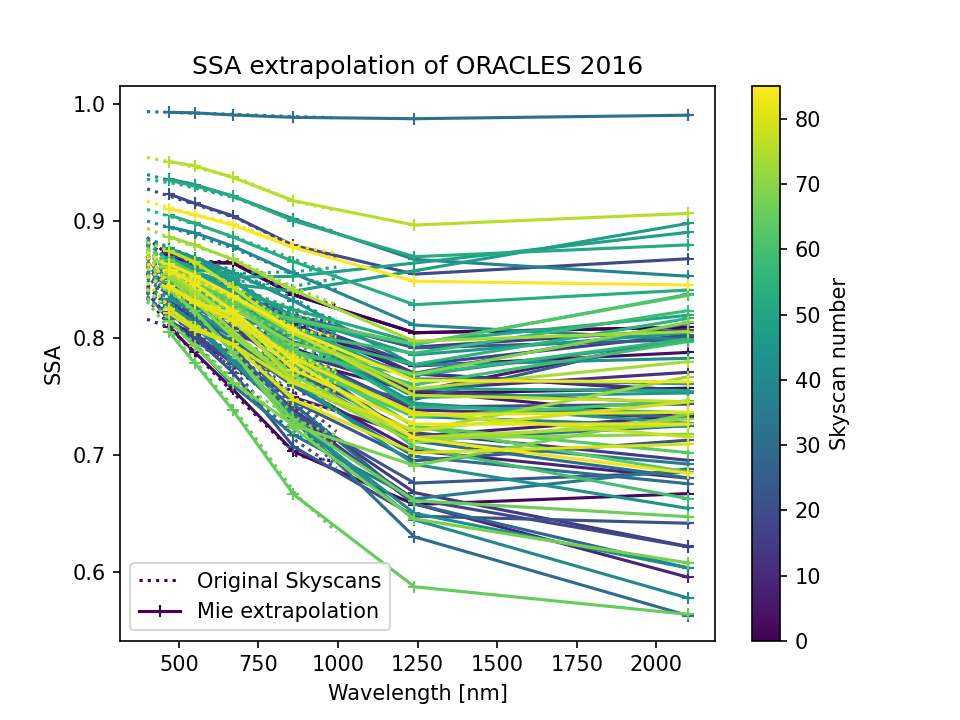

In [218]:
plt.figure()
it=0
plt.plot(ae[b'wavelength'],ae[b'SSA'][it,:],':',c=plt.cm.viridis(it*3),label='Original Skyscans')
plt.plot(wave_out,dats[it]['ssa'],'+-',c=plt.cm.viridis(it*3),label='Mie extrapolation')
for it,t in list(enumerate(ae[b'time'])):
    plt.plot(ae[b'wavelength'],ae[b'SSA'][it,:],':',c=plt.cm.viridis(it*3))
    plt.plot(wave_out,dats[it]['ssa'],'+-',c=plt.cm.viridis(it*3))
plt.legend()
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis,norm=plt.Normalize(vmin=0,vmax=it))
plt.colorbar(sm,label='Skyscan number')
plt.title('SSA extrapolation of ORACLES 2016')
plt.xlabel('Wavelength [nm]')
plt.ylabel('SSA')
plt.savefig(fpt+'SSA_mie_extrapolation_ORACLES2016_{}.png'.format(vv),dpi=600,transparent=True)

<IPython.core.display.Javascript object>


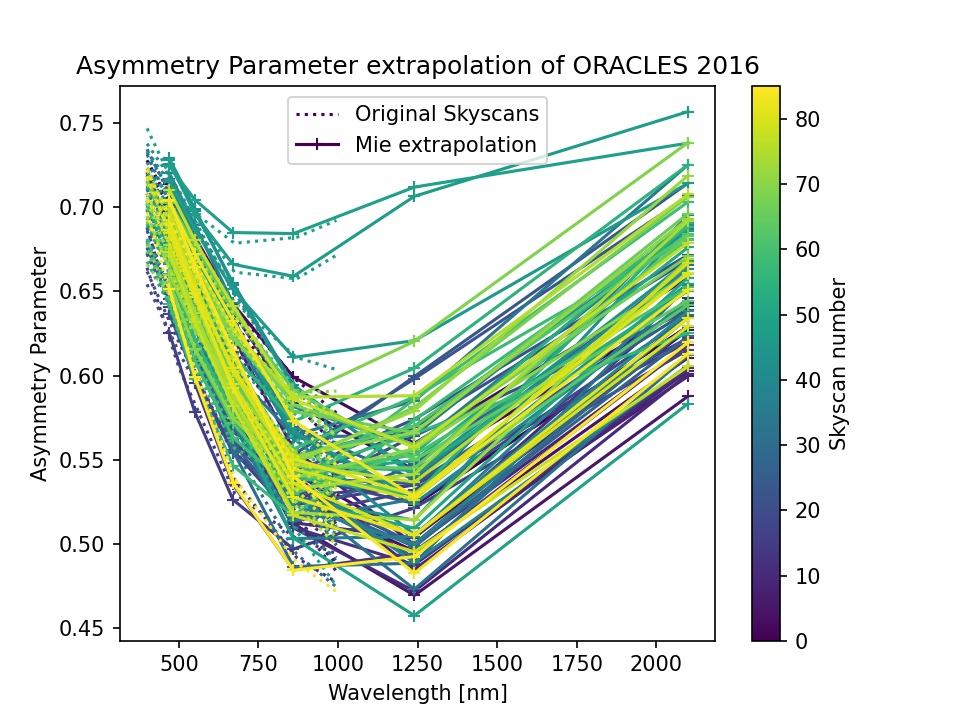

In [221]:
plt.figure()
it=0
plt.plot(ae[b'wavelength'],ae[b'g_total'][it,:],':',c=plt.cm.viridis(it*3),label='Original Skyscans')
plt.plot(wave_out,dats[it]['asym'],'+-',c=plt.cm.viridis(it*3),label='Mie extrapolation')
for it,t in list(enumerate(ae[b'time'])):
    plt.plot(ae[b'wavelength'],ae[b'g_total'][it,:],':',c=plt.cm.viridis(it*3))
    plt.plot(wave_out,dats[it]['asym'],'+-',c=plt.cm.viridis(it*3))
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis,norm=plt.Normalize(vmin=0,vmax=it))
plt.colorbar(sm,label='Skyscan number')
plt.title('Asymmetry Parameter extrapolation of ORACLES 2016')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Asymmetry Parameter')
plt.legend()
    
plt.savefig(fpt+'ASYM_mie_extrapolation_ORACLES2016_{}.png'.format(vv),dpi=600,transparent=True)

## Save as netcdf

### Copy file data and attributes from older one

In [163]:
fpt = '/data/sam/TASNPP/ORACLES_aerosol_prop/'
f_out = fpt + '4STAR-aeroinv_mie_wavelength_expansion_P3_2016_R0.nc'

In [164]:
f_in = fp + 'data_archival/AEROINV_nc_R0/NC_FORMAT_NETCDF4_CLASSIC/4STAR-aeroinv_P3_2016_R0.nc'

In [168]:
toexclude = ['ExcludeVar1', 'ExcludeVar2']

with nc.Dataset(f_in) as src, nc.Dataset(f_out, "w") as dst:
    # copy global attributes all at once via dictionary
    dst.setncatts(src.__dict__)
    # copy dimensions
    for name, dimension in src.dimensions.items():
        dst.createDimension(
            name, (len(dimension) if not dimension.isunlimited() else None))
    # copy all file data except for the excluded
    for name, variable in src.variables.items():
        if name not in toexclude:
            x = dst.createVariable(name, variable.datatype, variable.dimensions)
            # copy variable attributes all at once via dictionary
            dst[name].setncatts(src[name].__dict__)
            dst[name][:] = src[name][:]
            

### Update the Dataset with the new calculated ssa/asym

In [177]:
fn = nc.Dataset(f_out,'a')

In [178]:
fn

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    PI: Jens Redemann
    Institution: NASA Ames Research Center
    Instrument: Spectrometers for Sky-Scanning, Sun-Tracking Atmospheric Research (4STAR)
    Mission: ORACLES 2016
    PI_CONTACT_INFO: jredemann@ou.edu
    PLATFORM: NASA P3
    LOCATION: Based at Walvis Bay, Namibia, aircraft latitude, longitude, altitude are included in the data records
    DATA_INFO: Measurements represent airborne retrievals of aerosol properties derived from direct beam and angularly-resolved sky radiances at the location of the aircraft in the direction indicated by Az_sky and El_sky.  All measurements used in a single retrieval are reported at the time averaged over the sky scan.
    RETRIEVAL_INFO: Retrieval code was provided by AERONET (version 2 Aerosol Inversions), input files modified for airborne application.
    RETRIEVAL_DESCRIPTION: https://aeronet.gsfc.nasa.gov/new_web/Documents/Inversion_products_V2.p

In [180]:
fn.setncattr('History',"Modified By Samuel LeBlanc, 2022-09-14, to add wavelength-extrapolated SSA and Asymmetry Parameter, using Mie calculations of size distribution and extrapolated index of refraction")

In [191]:
fn.createDimension('Extrap_wavelength',len(dats[0]['wavelength']))
fn.createVariable('Extrap_wavelength','float64',('Extrap_wavelength'))
fn['Extrap_wavelength'].setncatts({'long_name':'Wavelengths from the extrapolated mie calculations','units':'nm'})
fn['Extrap_wavelength'][:] = dats[0]['wavelength'][:]

RuntimeError: NetCDF: String match to name in use

In [201]:
extraps = {}


extraps['n_real'] = {'data':np.array([da['n_real'] for da in dats]),
                     'atts':{'long_name':'Real refractive index, extrapolated in wavelength by Mie calculations',
                             'units':'None',
                             'history':'Built by Samuel LeBlanc on 2022-09-14'}}
extraps['n_imag'] = {'data':np.array([da['n_imag'] for da in dats]),
                     'atts':{'long_name':'Imaginary refractive index, extrapolated in wavelength by Mie calculations',
                             'units':'None',
                             'history':'Built by Samuel LeBlanc on 2022-09-14'}}
extraps['qext'] = {'data':np.array([da['qext'] for da in dats]),
                     'atts':{'long_name':'extinction efficiency factor, extrapolated in wavelength by Mie calculations',
                             'units':'cm^3/m^3',
                             'history':'Built by Samuel LeBlanc on 2022-09-14'}}
extraps['ssa'] = {'data':np.array([da['ssa'] for da in dats]),
                     'atts':{'long_name':'Single Scattering Albedo, extrapolated in wavelength by Mie calculations',
                             'units':'None',
                             'history':'Built by Samuel LeBlanc on 2022-09-14'}}
extraps['asym'] = {'data':np.array([da['asym'] for da in dats]),
                     'atts':{'long_name':'Asymmetry Parameter, extrapolated in wavelength by Mie calculations',
                             'units':'None',
                             'history':'Built by Samuel LeBlanc on 2022-09-14'}}

In [205]:
for k in extraps:
    fn.createVariable('Extrap_'+k,'float64',('time','Extrap_wavelength'))
    fn['Extrap_'+k].setncatts(extraps[k]['atts'])
    fn['Extrap_'+k][:] = extraps[k]['data']

In [206]:
fn

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    PI: Jens Redemann
    Institution: NASA Ames Research Center
    Instrument: Spectrometers for Sky-Scanning, Sun-Tracking Atmospheric Research (4STAR)
    Mission: ORACLES 2016
    PI_CONTACT_INFO: jredemann@ou.edu
    PLATFORM: NASA P3
    LOCATION: Based at Walvis Bay, Namibia, aircraft latitude, longitude, altitude are included in the data records
    DATA_INFO: Measurements represent airborne retrievals of aerosol properties derived from direct beam and angularly-resolved sky radiances at the location of the aircraft in the direction indicated by Az_sky and El_sky.  All measurements used in a single retrieval are reported at the time averaged over the sky scan.
    RETRIEVAL_INFO: Retrieval code was provided by AERONET (version 2 Aerosol Inversions), input files modified for airborne application.
    RETRIEVAL_DESCRIPTION: https://aeronet.gsfc.nasa.gov/new_web/Documents/Inversion_products_V2.p

In [207]:
fn.close()